In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score


In [2]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)

In [468]:
df_1d.tail(2)

,date,time,close,open,high,low,volume,var,return,diff,...,D,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR
4973,2024-08-23 23:59:09,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,NaN,0.187032,119.77,...,85.008494,64037.24,963.50,2532.836429,64060.836667,136.666548,2312.21,1434.22,2437.815000,2572.219286
4974,2024-08-25 00:00:57,1724544000000,64169.99,64157.02,64507.04,63773.27,8909.11990,NaN,0.020216,12.97,...,90.609019,64157.01,733.77,2330.157857,64150.100000,132.352502,2600.00,2437.56,2496.201429,2553.417143


In [3]:
fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)

# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas

In [4]:
df_1d.index = fechas

In [5]:
print(len(df_1d.index))
print(len(pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())))
                    #freq  = data_1d.index.freq)))
print(df_1d.index.min())
print(df_1d.index.max())

4983
4983
2011-01-12 00:00:00
2024-09-02 00:00:00


Corroborar que el indice sea unico y no tenga nulos.

In [6]:
print(df_1d.index.is_unique)
print(df_1d.index.hasnans)

True
False


Comprobaciones de consistencia de datos diarios: el código verifica si el índice del DataFrame df_1d contiene una secuencia diaria continua, garantizando que no haya fechas faltantes o espacios en los datos.

In [473]:
(df_1d.index == pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())).all()

True

In [21]:
last_date = df_1d['date'][-1:].values[0]
first_date = df_1d['date'][:2].values[0]
data_1d = df_1d.loc[first_date:last_date]
inicio_train = first_date
fin_train = last_date - pd.DateOffset(days=365)
fin_validacion = last_date - pd.DateOffset(days=1)

In [22]:
print("last_date",last_date)
print("first_date",first_date)
print("inicio_train",inicio_train)
print("fin_train",fin_train)
print("fin_validacion",fin_validacion)

last_date 2024-09-02T00:00:00.000000000
first_date 2011-01-12T00:00:00.000000000
inicio_train 2011-01-12T00:00:00.000000000
fin_train 2023-09-03 00:00:00
fin_validacion 2024-09-01 00:00:00


In [ ]:

inicio_train = '2012-01-18 00:00:00'
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

In [474]:
df_1d['date'] = df_1d['date'].dt.date.astype(str) + ' 00:00:00'

In [475]:
#df_1d.reset_index(inplace=True)

In [476]:
#df_1d['index'] = df_1d['index'].dt.date.astype(str) + ' 00:00:00'
#df_1d['index'] = pd.to_datetime(df_1d['index'])
#df_1d['index'] = df_1d['index'].dt.date.astype(str) + ' 00:00:00'

In [477]:
df_1d.index

DatetimeIndex(['2011-01-12 00:00:57', '2011-01-13 00:00:57',
               '2011-01-14 00:00:57', '2011-01-15 00:00:57',
               '2011-01-16 00:00:57', '2011-01-17 00:00:57',
               '2011-01-18 00:00:57', '2011-01-19 00:00:57',
               '2011-01-20 00:00:57', '2011-01-21 00:00:57',
               ...
               '2024-08-16 00:00:57', '2024-08-17 00:00:57',
               '2024-08-18 00:00:57', '2024-08-19 00:00:57',
               '2024-08-20 00:00:57', '2024-08-21 00:00:57',
               '2024-08-22 00:00:57', '2024-08-23 00:00:57',
               '2024-08-24 00:00:57', '2024-08-25 00:00:57'],
              dtype='datetime64[ns]', length=4975, freq='D')

In [478]:
#df_1d['index'] = df_1d['index'].astype(dtype='datetime64[ns]')
#df_1d.set_index(keys='index',inplace=True)

# Pronosticador Autoregresivo o ForecasterAutoreg

In [479]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=2,learning_rate=0.2,n_estimators=100,random_state=123),
    lags = [5,10,25,50,100,150,300]
)


In [480]:
forecaster.summary

<bound method ForecasterBase.summary of ================= 
ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.2, max_depth=2, random_state=123) 
Lags: [  5  10  25  50 100 150 300] 
Transformer for y: None 
Transformer for exog: None 
Window size: 300 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-08-31 18:55:10 
Last fit dat

In [481]:
#df_1d.loc['2012-01-18 00:00:00':'2024-07-20 00:00:00'].shape

### Fechas de entrenamiento y validacion

In [482]:
df_1d.index

DatetimeIndex(['2011-01-12 00:00:57', '2011-01-13 00:00:57',
               '2011-01-14 00:00:57', '2011-01-15 00:00:57',
               '2011-01-16 00:00:57', '2011-01-17 00:00:57',
               '2011-01-18 00:00:57', '2011-01-19 00:00:57',
               '2011-01-20 00:00:57', '2011-01-21 00:00:57',
               ...
               '2024-08-16 00:00:57', '2024-08-17 00:00:57',
               '2024-08-18 00:00:57', '2024-08-19 00:00:57',
               '2024-08-20 00:00:57', '2024-08-21 00:00:57',
               '2024-08-22 00:00:57', '2024-08-23 00:00:57',
               '2024-08-24 00:00:57', '2024-08-25 00:00:57'],
              dtype='datetime64[ns]', length=4975, freq='D')

In [483]:
data_1d = df_1d.loc['2012-01-18 00:00:00':'2024-08-25 00:00:57']
inicio_train = '2012-01-18 00:00:00'
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

In [484]:
datos_train = data_1d.loc[:fin_train,:] # 2 años y 3 meses
datos_val = data_1d.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = data_1d.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2012-01-18 00:00:57 --- 2023-07-14 00:00:57  (n=4196)
Fechas validacion : 2023-07-15 00:00:57 --- 2024-07-14 00:00:57  (n=366)
Fechas test : 2024-07-15 00:00:57 --- 2024-08-25 00:00:57  (n=42)


In [485]:
data_1d.loc[:fin_train,'partition'] = 'train'
data_1d.loc[fin_train:fin_validacion,'partition'] = 'validation'
data_1d.loc[fin_validacion:,'partition'] = 'test'

## Crear el gráfico
#plt.figure(figsize=(10, 4))
#for partition in ['train', 'validation', 'test']:
#    subset = data_1d[data_1d['partition'] == partition]
#    plt.plot(subset['date'], subset['close'], label=partition)
#
#plt.title('BTC Train, Validation and Test')
#plt.xlabel('Date')
#plt.ylabel('Close Price')
#plt.legend()
#plt.grid(True)
#plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\806169297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d.loc[:fin_train,'partition'] = 'train'


In [486]:
data_1d.reset_index(inplace=True)
data_1d['index'] = pd.to_datetime(data_1d['index'])
data_1d['index'] = data_1d['index'].dt.date.astype(str) + ' 00:00:00'

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\1295381833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['index'] = pd.to_datetime(data_1d['index'])
C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\1295381833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['index'] = data_1d['index'].dt.date.astype(str) + ' 00:00:00'


In [487]:
data_1d.set_index(keys='index',inplace=True)

In [488]:
data_1d

,date,time,close,open,high,low,volume,var,return,diff,...,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR,partition
index,,,,,,,,,,,,,,,,,,,,,
2012-01-18 00:00:00,2012-01-18 00:00:00,1326844800000,5.90,5.60,6.90,5.10,226680.00000,5.71,5.357143,0.30,...,5.60,1.80,0.985714,5.966667,-8.053550,0.30,0.20,0.192857,0.485714,train
2012-01-19 00:00:00,2012-01-19 00:00:00,1326931200000,6.40,5.90,6.40,5.90,114820.00000,7.43,8.474576,0.50,...,5.90,0.50,0.907143,6.233333,5.719207,0.10,0.40,0.192857,0.442857,train
2012-01-20 00:00:00,2012-01-20 00:00:00,1327017600000,6.50,6.40,6.60,6.30,66790.00000,2.04,1.562500,0.10,...,6.40,0.30,0.850000,6.466667,21.175950,0.10,0.80,0.200000,0.464286,train
2012-01-21 00:00:00,2012-01-21 00:00:00,1327104000000,6.20,6.50,6.60,6.10,64760.00000,-4.78,-4.615385,-0.30,...,6.50,0.50,0.842857,6.300000,-2.266696,0.20,0.20,0.207143,0.450000,train
2012-01-22 00:00:00,2012-01-22 00:00:00,1327190400000,6.30,6.20,6.40,6.10,44890.00000,2.10,1.612903,0.10,...,6.20,0.30,0.828571,6.266667,-13.823407,0.10,0.70,0.192857,0.485714,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21 00:00:00,2024-08-21 00:00:00,1724198400000,59627.99,59013.80,59739.52,58783.47,4256.46055,NaN,1.040757,614.19,...,59013.80,956.05,2826.030714,59383.660000,11.245504,2725.09,3783.96,2481.473571,2600.349286,test
2024-08-22 00:00:00,2024-08-22 00:00:00,1724284800000,60375.84,61156.03,61400.00,59724.87,21241.20588,NaN,-1.275737,-780.19,...,59627.99,1772.01,2380.092857,60500.236667,56.292016,3976.57,2649.88,2410.671429,2555.197143,test
2024-08-23 00:00:00,2024-08-23 00:00:00,1724371200000,64037.24,60375.83,64955.00,60342.14,38118.07089,NaN,6.064364,3661.41,...,60375.84,4612.86,2551.770714,63111.460000,133.044828,2006.55,1110.00,2399.500714,2561.060714,test


In [489]:
forecaster.fit(y=data_1d.loc[:fin_validacion,'close'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 7
[LightGBM] [Info] Start training from score 14402.520478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:815: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:815: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


In [490]:
predicciones = forecaster.predict(steps=5)
predicciones

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:877: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


300    57250.350107
301    59421.015326
302    57948.946041
303    62634.460764
304    61549.964344
Name: pred, dtype: float64

In [491]:
#data_1d['date'] = pd.to_datetime(data_1d['date'], format="%Y-%m-%d %H:%M:%S")


In [492]:
#data_1d['date'] = pd.to_datetime(data_1d['date'],format="%Y-%m-%d %H:%M:%S")

In [493]:
data_1d

,date,time,close,open,high,low,volume,var,return,diff,...,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR,partition
index,,,,,,,,,,,,,,,,,,,,,
2012-01-18 00:00:00,2012-01-18 00:00:00,1326844800000,5.90,5.60,6.90,5.10,226680.00000,5.71,5.357143,0.30,...,5.60,1.80,0.985714,5.966667,-8.053550,0.30,0.20,0.192857,0.485714,train
2012-01-19 00:00:00,2012-01-19 00:00:00,1326931200000,6.40,5.90,6.40,5.90,114820.00000,7.43,8.474576,0.50,...,5.90,0.50,0.907143,6.233333,5.719207,0.10,0.40,0.192857,0.442857,train
2012-01-20 00:00:00,2012-01-20 00:00:00,1327017600000,6.50,6.40,6.60,6.30,66790.00000,2.04,1.562500,0.10,...,6.40,0.30,0.850000,6.466667,21.175950,0.10,0.80,0.200000,0.464286,train
2012-01-21 00:00:00,2012-01-21 00:00:00,1327104000000,6.20,6.50,6.60,6.10,64760.00000,-4.78,-4.615385,-0.30,...,6.50,0.50,0.842857,6.300000,-2.266696,0.20,0.20,0.207143,0.450000,train
2012-01-22 00:00:00,2012-01-22 00:00:00,1327190400000,6.30,6.20,6.40,6.10,44890.00000,2.10,1.612903,0.10,...,6.20,0.30,0.828571,6.266667,-13.823407,0.10,0.70,0.192857,0.485714,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21 00:00:00,2024-08-21 00:00:00,1724198400000,59627.99,59013.80,59739.52,58783.47,4256.46055,NaN,1.040757,614.19,...,59013.80,956.05,2826.030714,59383.660000,11.245504,2725.09,3783.96,2481.473571,2600.349286,test
2024-08-22 00:00:00,2024-08-22 00:00:00,1724284800000,60375.84,61156.03,61400.00,59724.87,21241.20588,NaN,-1.275737,-780.19,...,59627.99,1772.01,2380.092857,60500.236667,56.292016,3976.57,2649.88,2410.671429,2555.197143,test
2024-08-23 00:00:00,2024-08-23 00:00:00,1724371200000,64037.24,60375.83,64955.00,60342.14,38118.07089,NaN,6.064364,3661.41,...,60375.84,4612.86,2551.770714,63111.460000,133.044828,2006.55,1110.00,2399.500714,2561.060714,test


In [433]:
#data_1d.index = pd.to_datetime(data_1d.index, format="%Y-%m-%d %H:%M:%S")


In [495]:
from datetime import datetime

In [496]:
# Suponiendo que tu índice actual es de tipo objeto y tiene el formato 'Y-m-d H:M:S'
data_1d.index = [datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S") for date_str in data_1d.index]

In [499]:
data_1d['date'] = pd.to_datetime(data_1d['date'], format="%Y-%m-%d %H:%M:%S")

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\3079564197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['date'] = pd.to_datetime(data_1d['date'], format="%Y-%m-%d %H:%M:%S")


KeyError: 'None of [RangeIndex(start=300, stop=305, step=1)] are in the [index]'

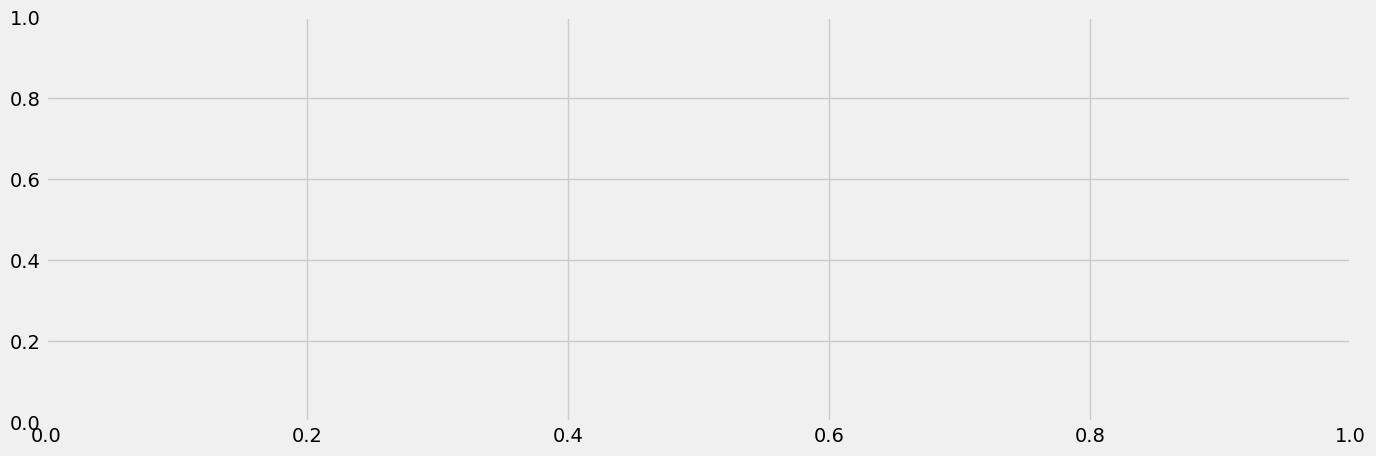

In [434]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [305]:
# Error test
# ==============================================================================
#r2 = r2_score(
#                y_true = datos_test['close'],
#                y_pred = predicciones
#            )
#print(f"Error de test (mse): {r2}")

# Optimizacion de hiperparametros


In [306]:
## Búsqueda de hiperparámetros: grid search
## ==============================================================================
#steps = 19
#forecaster = ForecasterAutoreg(
#                regressor = LGBMRegressor(random_state=123),
#                lags      = 12 # Este valor será remplazado en el grid search
#             )
#
## Valores candidatos de lags
#lags_grid = [[10,25,50,75,100],
#             [50,100,150,200],
#             [30,180,360],
#             [5,25,50]]
#
## Valores candidatos de hiperparámetros del regresor
#param_grid = {
#      'n_estimators': [100, 250,500],
#      'max_depth': [3, 5, 10],
#      'learning_rate': [0.1,0.01]
#}
#
#resultados_grid = grid_search_forecaster(
#                        forecaster         = forecaster,
#                        y                  = datos_train['close'],
#                        param_grid         = param_grid,
#                        lags_grid          = lags_grid,
#                        steps              = steps,
#                        refit              = False,
#                        metric             = 'mean_squared_error',
#                        initial_train_size = int(len(datos_train)*0.5),
#                        fixed_train_size   = False,
#                        return_best        = True,
#                        n_jobs             = 'auto',
#                        verbose            = False
#                  )

In [307]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=5,learning_rate=0.1,n_estimators=500,random_state=123),
    lags = [1,50,100]
)

In [308]:
forecaster.fit(y=datos_train['close'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 3
[LightGBM] [Info] Start training from score 10782.801034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [309]:
steps=42
predicciones = forecaster.predict(steps=steps)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

KeyError: "None of [DatetimeIndex(['2023-07-15 00:00:57', '2023-07-16 00:00:57',\n               '2023-07-17 00:00:57', '2023-07-18 00:00:57',\n               '2023-07-19 00:00:57', '2023-07-20 00:00:57',\n               '2023-07-21 00:00:57', '2023-07-22 00:00:57',\n               '2023-07-23 00:00:57', '2023-07-24 00:00:57',\n               '2023-07-25 00:00:57', '2023-07-26 00:00:57',\n               '2023-07-27 00:00:57', '2023-07-28 00:00:57',\n               '2023-07-29 00:00:57', '2023-07-30 00:00:57',\n               '2023-07-31 00:00:57', '2023-08-01 00:00:57',\n               '2023-08-02 00:00:57', '2023-08-03 00:00:57',\n               '2023-08-04 00:00:57', '2023-08-05 00:00:57',\n               '2023-08-06 00:00:57', '2023-08-07 00:00:57',\n               '2023-08-08 00:00:57', '2023-08-09 00:00:57',\n               '2023-08-10 00:00:57', '2023-08-11 00:00:57',\n               '2023-08-12 00:00:57', '2023-08-13 00:00:57',\n               '2023-08-14 00:00:57', '2023-08-15 00:00:57',\n               '2023-08-16 00:00:57', '2023-08-17 00:00:57',\n               '2023-08-18 00:00:57', '2023-08-19 00:00:57',\n               '2023-08-20 00:00:57', '2023-08-21 00:00:57',\n               '2023-08-22 00:00:57', '2023-08-23 00:00:57',\n               '2023-08-24 00:00:57', '2023-08-25 00:00:57'],\n              dtype='datetime64[ns]', freq='D')] are in the [index]"

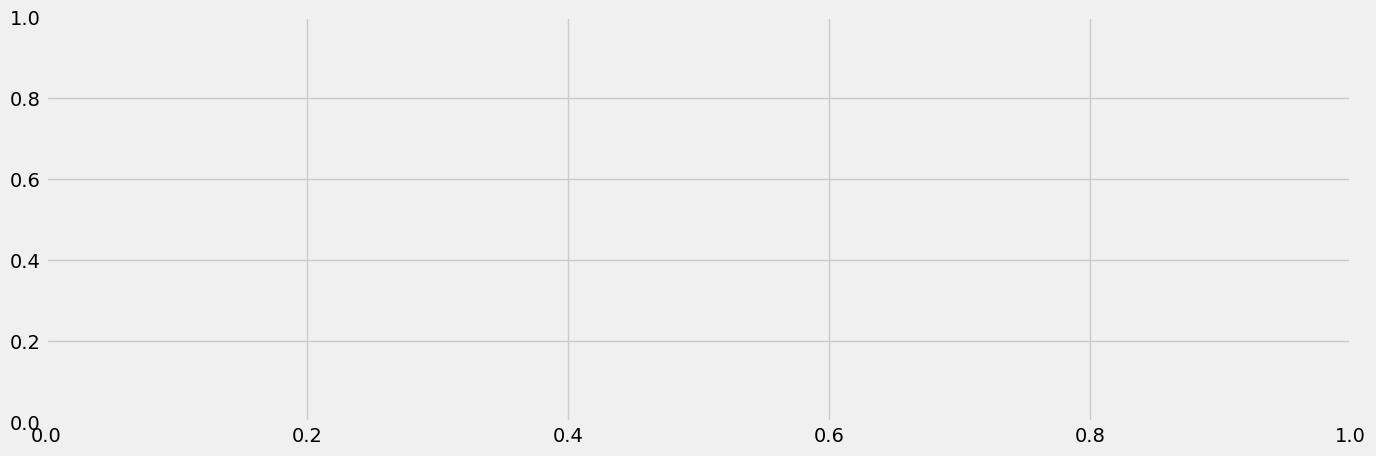

In [310]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1061649943.5806615


In [ ]:
# Error test
# ==============================================================================
r2 = r2_score(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {r2}")

Error de test (mse): -70.45289914226642


# Variables exogenas

In [ ]:
data_1d['index'] = data_1d['index'].astype(dtype='datetime64[ns]')
data_1d.set_index(keys='index',inplace=True)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\1194611142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['index'] = data_1d['index'].astype(dtype='datetime64[ns]')


In [ ]:
# One hot encoding de las variables categóricas
# ==============================================================================
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)
data[['reward_3.125', 'reward_12.5', 'reward_25.0',
       'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6',
       'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']].head(2)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11792\50150341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['mes'] = data_1d.index.month


,reward_3.125,reward_12.5,reward_25.0,reward_50.0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
index,,,,,,,,,,,,,,,,
2012-01-18,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-19,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_3.125',
 'reward_12.5',
 'reward_25.0',
 'reward_50.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [ ]:
data.drop(columns='var',inplace=True)

In [ ]:
data.tail(2)

,date,time,close,open,high,low,volume,return,diff,volatility,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
index,,,,,,,,,,,,,,,,,,,,,
2024-08-24,2024-08-24 00:00:00,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,0.187032,119.77,963.50,...,0,0,0,0,0,1,0,0,0,0
2024-08-25,2024-08-25 00:00:00,1724544000000,64169.99,64157.02,64507.04,63773.27,8909.11990,0.020216,12.97,733.77,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data.reset_index(inplace=True)
data['index'] = data['index'].dt.date.astype(str) + ' 00:00:00'

In [ ]:
data

,index,date,time,close,open,high,low,volume,return,diff,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,2012-01-18 00:00:00,2012-01-18 00:00:00,1326844800000,5.90,5.60,6.90,5.10,226680.00000,5.357143,0.30,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-19 00:00:00,2012-01-19 00:00:00,1326931200000,6.40,5.90,6.40,5.90,114820.00000,8.474576,0.50,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-20 00:00:00,2012-01-20 00:00:00,1327017600000,6.50,6.40,6.60,6.30,66790.00000,1.562500,0.10,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-21 00:00:00,2012-01-21 00:00:00,1327104000000,6.20,6.50,6.60,6.10,64760.00000,-4.615385,-0.30,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-22 00:00:00,2012-01-22 00:00:00,1327190400000,6.30,6.20,6.40,6.10,44890.00000,1.612903,0.10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,2024-08-21 00:00:00,2024-08-21 00:00:00,1724198400000,59627.99,59013.80,59739.52,58783.47,4256.46055,1.040757,614.19,...,0,0,0,0,0,1,0,0,0,0
4600,2024-08-22 00:00:00,2024-08-22 00:00:00,1724284800000,60375.84,61156.03,61400.00,59724.87,21241.20588,-1.275737,-780.19,...,0,0,0,0,0,1,0,0,0,0
4601,2024-08-23 00:00:00,2024-08-23 00:00:00,1724371200000,64037.24,60375.83,64955.00,60342.14,38118.07089,6.064364,3661.41,...,0,0,0,0,0,1,0,0,0,0
4602,2024-08-24 00:00:00,2024-08-24 00:00:00,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,0.187032,119.77,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data['index'] = data['index'].astype(dtype='datetime64[ns]')
data.set_index(keys='index',inplace=True)

In [ ]:
print(data.loc[inicio_train:, 'close'].isnull().sum())
print(data.loc[inicio_train:, exog].isnull().sum())


0
reward_3.125         0
reward_12.5          0
reward_25.0          0
reward_50.0          0
mes_1                0
mes_2                0
mes_3                0
mes_4                0
mes_5                0
mes_6                0
mes_7                0
mes_8                0
mes_9                0
mes_10               0
mes_11               0
mes_12               0
countdown_halving    0
dtype: int64


In [ ]:
data

,date,time,close,open,high,low,volume,return,diff,volatility,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
index,,,,,,,,,,,,,,,,,,,,,
2012-01-18,2012-01-18 00:00:00,1326844800000,5.90,5.60,6.90,5.10,226680.00000,5.357143,0.30,1.80,...,0,0,0,0,0,0,0,0,0,0
2012-01-19,2012-01-19 00:00:00,1326931200000,6.40,5.90,6.40,5.90,114820.00000,8.474576,0.50,0.50,...,0,0,0,0,0,0,0,0,0,0
2012-01-20,2012-01-20 00:00:00,1327017600000,6.50,6.40,6.60,6.30,66790.00000,1.562500,0.10,0.30,...,0,0,0,0,0,0,0,0,0,0
2012-01-21,2012-01-21 00:00:00,1327104000000,6.20,6.50,6.60,6.10,64760.00000,-4.615385,-0.30,0.50,...,0,0,0,0,0,0,0,0,0,0
2012-01-22,2012-01-22 00:00:00,1327190400000,6.30,6.20,6.40,6.10,44890.00000,1.612903,0.10,0.30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-21,2024-08-21 00:00:00,1724198400000,59627.99,59013.80,59739.52,58783.47,4256.46055,1.040757,614.19,956.05,...,0,0,0,0,0,1,0,0,0,0
2024-08-22,2024-08-22 00:00:00,1724284800000,60375.84,61156.03,61400.00,59724.87,21241.20588,-1.275737,-780.19,1675.13,...,0,0,0,0,0,1,0,0,0,0
2024-08-23,2024-08-23 00:00:00,1724371200000,64037.24,60375.83,64955.00,60342.14,38118.07089,6.064364,3661.41,4612.86,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = False,
                            show_progress      = True
                        )

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:929: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:548: LongTrainingWarning: The forecaster will be fit 407 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using

  0%|          | 0/407 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

KeyError: 'None of [RangeIndex(start=100, stop=142, step=1)] are in the [index]'

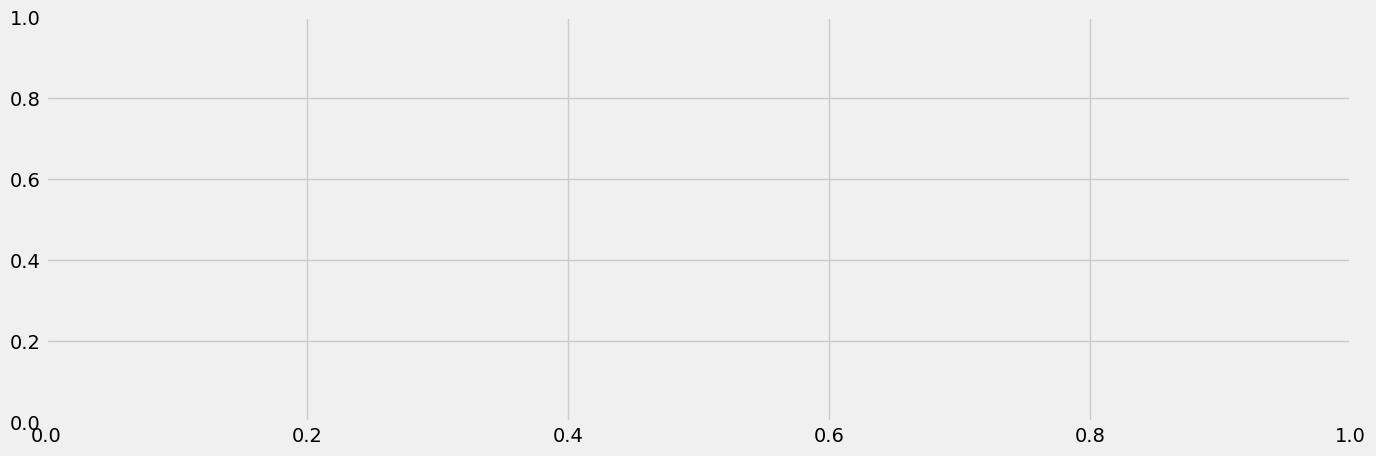

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()


In [ ]:
metrica

0.021224118833320853

el precio de Bitcoin no sigue un patrón autorregresivo, la mejor estimación para el valor  tn+1es el valor  tn
 más un cambio impredecible. La identificación temprana de la ausencia de esta correlación mediante análisi descriptivo evita esfuerzos de modelado innecesarios.

Cuando se dispone de una serie temporal con ausencia de autocorrelación se deben buscar variables exógenas capaces de ayudar en el problema. Por ejemplo, si se intentase predecir el precio de Bitcoin a corto plazo (horas) podrían emplearse como variables exógenas el sentimiento del mercado mediante el análisis de tweets, impacto de los denominados key opinion leaders, análisis de noticias más relevantes, etc.

Utilizar modelos de machine learning en problemas de forecasting es muy sencillo gracias a las funcionalidades ofrecidas por Skforecast.

In [ ]:
# Suponiendo que 'data_1d' es tu dataframe con la serie temporal
# Asegúrate de que 'data_1d' esté ordenado por fecha
data = data.sort_index()


In [ ]:
# Definir el forecaster con el modelo y el lag
forecaster = ForecasterAutoreg(
    regressor=LGBMRegressor(random_state=123, verbose=-1),
    lags=1  # Puedes ajustar el número de lags según tu necesidad
)

In [ ]:
# Ajustar el modelo con todos los datos disponibles
forecaster.fit(y=data['close'], exog=data[exog])

In [ ]:
exog = data[exog]

In [ ]:
type(exog)

pandas.core.frame.DataFrame

In [ ]:
fecha_inicio_prediccion = pd.to_datetime('2024-08-26 00:00:57')

In [ ]:
# Crear un nuevo dataframe para las predicciones futuras
n_steps = 10  # Número de pasos hacia el futuro que quieres predecir
fechas_futuras = pd.date_range(start=fecha_inicio_prediccion, periods=n_steps, freq='D')

In [ ]:
exog_futuro = exog

In [ ]:
# Crear valores exógenos futuros para todas las columnas en exog
exog_futuro = pd.DataFrame({
    'reward_3.125': [0] * len(fechas_futuras),  # Ajusta según los valores futuros esperados
    'reward_12.5': [0] * len(fechas_futuras),   # Ajusta según los valores futuros esperados
    'reward_25.0': [0] * len(fechas_futuras),   # Ajusta según los valores futuros esperados
    'reward_50.0': [0] * len(fechas_futuras),   # Ajusta según los valores futuros esperados
    'mes_1': [0] * len(fechas_futuras),         # Coloca el valor correcto si sabes que será un determinado mes
    'mes_2': [0] * len(fechas_futuras),         # Mismo ajuste para los meses
    'mes_3': [0] * len(fechas_futuras),
    'mes_4': [0] * len(fechas_futuras),
    'mes_5': [0] * len(fechas_futuras),
    'mes_6': [0] * len(fechas_futuras),
    'mes_7': [0] * len(fechas_futuras),
    'mes_8': [0] * len(fechas_futuras),
    'mes_9': [0] * len(fechas_futuras),
    'mes_10': [0] * len(fechas_futuras),
    'mes_11': [0] * len(fechas_futuras),
    'mes_12': [0] * len(fechas_futuras),
    'countdown_halving': [0] * len(fechas_futuras)  # Ajusta según el valor futuro esperado
}, index=fechas_futuras)
import Scripts.funciones as func
exog_futuro.reset_index(names='date',inplace=True)
exog_futuro = func.calcular_recompensa_y_cuenta_regresiva_1d(exog_futuro)
#exog_futuro.set_index(keys='date')
exog_futuro.sort_index(inplace=True)

exog_futuro.reset_index(inplace=True)

El próximo halving ocurrirá aproximadamente el: 2026-07-25 10:40:00


In [ ]:
exog_futuro.index = pd.to_datetime(exog_futuro['date'])

In [ ]:
print(type(exog_futuro.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
exog_futuro.drop(columns=['index','date'],inplace=True)

In [ ]:
exog_futuro['mes'] = exog_futuro.index.month
exog_futuro = pd.get_dummies(exog_futuro,columns=['reward','mes'])

In [ ]:
exog_futuro.index

DatetimeIndex(['2024-08-26 00:00:57', '2024-08-27 00:00:57',
               '2024-08-28 00:00:57', '2024-08-29 00:00:57',
               '2024-08-30 00:00:57', '2024-08-31 00:00:57',
               '2024-09-01 00:00:57', '2024-09-02 00:00:57',
               '2024-09-03 00:00:57', '2024-09-04 00:00:57'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
exog_prueba = exog_futuro.iloc[-1:]

In [ ]:
exog_prueba.index

DatetimeIndex(['2024-09-04 00:00:57'], dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
exog_futuro.reset_index(inplace=True)

In [ ]:
exog_futuro['date'] = exog_futuro['date'].dt.date.astype(str) + ' 00:00:00'

In [ ]:
data

DatetimeIndex(['2012-01-18 00:00:57', '2012-01-19 00:00:57',
               '2012-01-20 00:00:57', '2012-01-21 00:00:57',
               '2012-01-22 00:00:57', '2012-01-23 00:00:57',
               '2012-01-24 00:00:57', '2012-01-25 00:00:57',
               '2012-01-26 00:00:57', '2012-01-27 00:00:57',
               ...
               '2024-08-16 00:00:57', '2024-08-17 00:00:57',
               '2024-08-18 00:00:57', '2024-08-19 00:00:57',
               '2024-08-20 00:00:57', '2024-08-21 00:00:57',
               '2024-08-22 00:00:57', '2024-08-23 00:00:57',
               '2024-08-24 00:00:57', '2024-08-25 00:00:57'],
              dtype='datetime64[ns]', length=4604, freq='D')

In [ ]:
predicciones = []
for i in range(10):  # Predice 10 pasos hacia el futuro
    pred = forecaster.predict(steps=1, exog=exog_futuro.iloc[[i]])
    predicciones.append(pred)
    # Aquí podrías actualizar exog_futuro si es necesario para el próximo paso
predicciones_futuras = pd.concat(predicciones)


c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:940: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


TypeError: Expected index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> for `exog`. Got <class 'pandas.core.indexes.range.RangeIndex'>.

In [ ]:
# Predicción sobre el último valor
prediccion_ultimo_valor = forecaster.predict(steps=1, exog=exog_futuro.iloc[-1:])

TypeError: Expected index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> for `exog`. Got <class 'pandas.core.indexes.range.RangeIndex'>.

In [ ]:
# One hot encoding de las variables categóricas
# ==============================================================================
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)

# Selección de variables exógenas
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])

# Definir y entrenar el forecaster con todos los datos
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Entrenamiento del modelo con todos los datos
forecaster.fit(y=data['close'], exog=data[exog])

# Predicción del último valor y 5 valores futuros
# ==============================================================================
steps_a_predecir = 6  # Incluye el último valor y 5 valores futuros

# Selecciona los últimos datos para las predicciones
ultimo_valor = data.iloc[-1, :]  # Última fila del dataframe

C:\Users\Pablo\AppData\Local\Temp\ipykernel_15176\136776677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['mes'] = data_1d.index.month


In [ ]:
exog_ultimos = data[exog].iloc[-forecaster.lags:]  # Últimos datos de las variables exógenas

TypeError: cannot do positional indexing on RangeIndex with these indexers [[-1]] of type ndarray

In [ ]:
# One hot encoding de las variables categóricas
# ==============================================================================
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)

# Selección de variables exógenas
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])

# Definir y entrenar el forecaster con todos los datos
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Entrenamiento del modelo con todos los datos
forecaster.fit(y=data['close'], exog=data[exog])

# Predicción del último valor y 5 valores futuros
# ==============================================================================
steps_a_predecir = 6  # Incluye el último valor y 5 valores futuros

# Selecciona los últimos datos para las predicciones
ultimo_valor = data.iloc[-1, :]  # Última fila del dataframe
exog_ultimos = data[exog].iloc[-forecaster.lags:]  # Últimos datos de las variables exógenas

# Predice el último valor y los 5 futuros
predicciones_futuras = forecaster.predict(steps=steps_a_predecir, exog=exog_ultimos)

# Mostrar resultados
print("Predicciones del último valor y 5 futuros:")
print(predicciones_futuras)


TypeError: cannot do positional indexing on DatetimeIndex with these indexers [[-1]] of type ndarray

In [ ]:
data_1d = df_1d.loc['2012-01-18 00:00:00':'2024-08-25 00:00:57']
inicio_train = '2012-01-18 00:00:00'
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

datos_train = data_1d.loc[:fin_train,:] # 2 años y 3 meses
datos_val = data_1d.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = data_1d.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = False,
                            show_progress      = True
                        )


C:\Users\Pablo\AppData\Local\Temp\ipykernel_15176\3815513652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['mes'] = data_1d.index.month


TypeError: cannot do positional indexing on DatetimeIndex with these indexers [[-1]] of type ndarray

In [ ]:
# Parte 1: Crear el dataframe futuro
fecha_maxima = df_1d.index.max()
fecha_maxima_timestamp = pd.Timestamp(fecha_maxima)
seis_dias = fecha_maxima_timestamp + pd.DateOffset(days=6)
future = pd.date_range(fecha_maxima, seis_dias)
print(fecha_maxima)
print(fecha_maxima_timestamp)
print(seis_dias)
print(future)

2024-08-25 00:00:57
2024-08-25 00:00:57
2024-08-31 00:00:57
DatetimeIndex(['2024-08-25 00:00:57', '2024-08-26 00:00:57',
               '2024-08-27 00:00:57', '2024-08-28 00:00:57',
               '2024-08-29 00:00:57', '2024-08-30 00:00:57',
               '2024-08-31 00:00:57'],
              dtype='datetime64[ns]', freq='D')


In [ ]:
# Crear el dataframe futuro
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_1d['isFuture'] = False

In [ ]:
future_df.head(2)

,isFuture
2024-08-25 00:00:57,True
2024-08-26 00:00:57,True


In [ ]:
# Concatenar el dataframe futuro con los datos históricos
df_and_future = pd.concat([df_1d, future_df])

In [ ]:
df_and_future.columns

Index(['date', 'time', 'close', 'open', 'high', 'low', 'volume', 'var',
       'return', 'diff', 'volatility', 'reward', 'countdown_halving', 'rsi_14',
       'rsi_28', 'rsi_14_shifted', 'rsi_28_shifted', 'ma_5', 'ma_20', 'ma_100',
       'MiddleBand', 'UpperBand', 'LowerBand', 'K', 'D', 'close_shifted', 'TR',
       'ATR', 'TP', 'CCI', 'lag1_TR', 'lag2_TR', 'lag1_ATR', 'lag2_ATR',
       'isFuture'],
      dtype='object')

In [ ]:
df_and_future['mes'] = df_and_future.index.month
df_and_future = pd.get_dummies(df_and_future, columns=['reward', 'mes'], dtype=int)
df_and_future[['reward_3.125', 'reward_12.5', 'reward_25.0',
       'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6',
       'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']].tail(2)

,reward_3.125,reward_12.5,reward_25.0,reward_50.0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2024-08-30 00:00:57,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2024-08-31 00:00:57,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_3.125',
 'reward_12.5',
 'reward_25.0',
 'reward_50.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [ ]:
data_futuro = df_and_future[df_and_future['isFuture'] == True]

In [ ]:
# 1. Entrenamiento del modelo con todos los datos disponibles
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=123, verbose=-1),
    lags             = 1,
    transformer_y    = None,
    transformer_exog = None
)

In [ ]:
data_1d['mes'] = data_1d.index.month
data_1d = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_1596\1704069176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['mes'] = data_1d.index.month


In [ ]:
data_1d[['reward_3.125', 'reward_12.5', 'reward_25.0',
       'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6',
       'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']].tail(2)

,reward_3.125,reward_12.5,reward_25.0,reward_50.0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2024-08-24 00:00:57,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2024-08-25 00:00:57,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#data_1d = data_1d.dropna()

In [ ]:
data_1d.shape

(4604, 50)

In [ ]:
len(data_1d)

4604

In [ ]:
data_1d.fillna(0,inplace=True)

In [ ]:

ultima_fecha = data_1d.index[-1]

In [ ]:
ultima_fecha

Timestamp('2024-08-25 00:00:57')

In [ ]:
fin_validacion = ultima_fecha

In [ ]:
# Entrenar el modelo utilizando todo el periodo disponible
forecaster.fit(
    y=data_1d.loc[:fin_validacion,'close'],  # Usa toda la serie temporal histórica
    exog = data_1d[exog]      # Usa las variables exógenas definidas
)

In [ ]:
data_futuro

,date,time,close,open,high,low,volume,var,return,diff,...,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
2024-08-25 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-26 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-27 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-28 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-29 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-30 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2024-08-31 00:00:57,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data_futuro.index

DatetimeIndex(['2024-08-25 00:00:57', '2024-08-26 00:00:57',
               '2024-08-27 00:00:57', '2024-08-28 00:00:57',
               '2024-08-29 00:00:57', '2024-08-30 00:00:57',
               '2024-08-31 00:00:57'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
#data_futuro.index = pd.to_datetime(data_futuro.index)

In [ ]:
# Verifica que el índice sea del tipo correcto
if not isinstance(data_futuro.index, pd.DatetimeIndex):
    # Supongamos que la columna de fechas es 'fecha', si no está en el índice
    if 'fecha' in data_futuro.columns:
        data_futuro['fecha'] = pd.to_datetime(data_futuro['fecha'])
        data_futuro = data_futuro.set_index('fecha')
    else:
        # Si ya tienes un índice de rango, puedes convertirlo a DatetimeIndex
        data_futuro.index = pd.to_datetime(data_futuro.index)

In [ ]:
print(type(data_futuro.index))  # Debería ser <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
print(type(data_futuro[exog].index))  # También debería ser <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
data_futuro.index = pd.DatetimeIndex(data_futuro.index)

In [ ]:
data_futuro[exog].index

DatetimeIndex(['2024-08-25 00:00:57', '2024-08-26 00:00:57',
               '2024-08-27 00:00:57', '2024-08-28 00:00:57',
               '2024-08-29 00:00:57', '2024-08-30 00:00:57',
               '2024-08-31 00:00:57'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
data_futuro = data_futuro[1:]

In [ ]:
data.loc[inicio_train:, 'close']

2012-01-18 00:00:57        5.90
2012-01-19 00:00:57        6.40
2012-01-20 00:00:57        6.50
2012-01-21 00:00:57        6.20
2012-01-22 00:00:57        6.30
                         ...   
2024-08-21 00:00:57    59627.99
2024-08-22 00:00:57    60375.84
2024-08-23 00:00:57    64037.24
2024-08-24 00:00:57    64157.01
2024-08-25 00:00:57    64169.99
Freq: D, Name: close, Length: 4604, dtype: float64

In [ ]:
df_1d.tail(3)

,date,time,close,open,high,low,volume,var,return,diff,...,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR,isFuture
2024-08-23 00:00:57,2024-08-23 00:00:57,1724371200000,64037.24,60375.83,64955.00,60342.14,38118.07089,NaN,6.064364,3661.41,...,60375.84,4612.86,2551.770714,63111.460000,133.044828,2006.55,1110.00,2399.500714,2561.060714,False
2024-08-24 00:00:57,2024-08-24 00:00:57,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,NaN,0.187032,119.77,...,64037.24,963.50,2532.836429,64060.836667,136.666548,2312.21,1434.22,2437.815000,2572.219286,False
2024-08-25 00:00:57,2024-08-25 00:00:57,1724544000000,64169.99,64157.02,64507.04,63773.27,8909.11990,NaN,0.020216,12.97,...,64157.01,733.77,2330.157857,64150.100000,132.352502,2600.00,2437.56,2496.201429,2553.417143,False


In [ ]:
# 1. Obtener la última fecha de los datos históricos
ultima_fecha_historica = data.loc[inicio_train:, 'close'].index[-1]

In [ ]:
# 2. Verificar que la primera fecha de data_futuro siga inmediatamente a la última fecha histórica
primera_fecha_futuro = data_futuro.index[0]
print(f"Última fecha histórica: {ultima_fecha_historica}")
print(f"Primera fecha futura: {primera_fecha_futuro}")

Última fecha histórica: 2024-08-25 00:00:57
Primera fecha futura: 2024-08-26 00:00:57


In [ ]:
# 3. Verificar si la primera fecha de data_futuro es el día siguiente a la última fecha histórica
if primera_fecha_futuro == ultima_fecha_historica + pd.Timedelta(days=1):
    print("Las fechas están alineadas temporalmente.")
else:
    print("Las fechas no están alineadas temporalmente.")

Las fechas están alineadas temporalmente.


In [ ]:
# Ajustar el modelo con los datos históricos
forecaster.fit(y=data.loc[inicio_train:, 'close'], exog=data.loc[inicio_train:, exog])


In [ ]:
print(type(data_futuro.index))  # Verifica el tipo de índice


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
print(data.shape)
print(data_futuro.shape)

(4604, 50)
(6, 50)


In [ ]:
data.index

DatetimeIndex(['2012-01-18 00:00:57', '2012-01-19 00:00:57',
               '2012-01-20 00:00:57', '2012-01-21 00:00:57',
               '2012-01-22 00:00:57', '2012-01-23 00:00:57',
               '2012-01-24 00:00:57', '2012-01-25 00:00:57',
               '2012-01-26 00:00:57', '2012-01-27 00:00:57',
               ...
               '2024-08-16 00:00:57', '2024-08-17 00:00:57',
               '2024-08-18 00:00:57', '2024-08-19 00:00:57',
               '2024-08-20 00:00:57', '2024-08-21 00:00:57',
               '2024-08-22 00:00:57', '2024-08-23 00:00:57',
               '2024-08-24 00:00:57', '2024-08-25 00:00:57'],
              dtype='datetime64[ns]', length=4604, freq='D')

In [ ]:
# Si el índice no es de tipo DatetimeIndex, conviértelo
if not isinstance(data_futuro.index, pd.DatetimeIndex):
    data_futuro.index = pd.to_datetime(data_futuro.index)
    print(f"Índice convertido a: {type(data_futuro.index)}")

In [ ]:
# 2. Realizar predicciones sobre los datos futuros
# Usa solo los datos futuros para hacer la predicción
predicciones_futuras = forecaster.predict(
    steps = len(data_futuro),  # El número de pasos a predecir es el número de filas en data_futuro
    exog  = df_and_future.loc[:fin_validacion,exog]  # Las variables exógenas para el periodo futuro
)

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:660: MissingValuesExogWarning: `exog` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:929: UserWarning: `exog` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


TypeError: Expected index of type <class 'pandas.core.indexes.datetimes.DatetimeIndex'> for `exog`. Got <class 'pandas.core.indexes.range.RangeIndex'>.

In [ ]:
forecaster.fit(y=data_1d.loc[:fin_validacion,'close'])

AttributeError: 'list' object has no attribute 'name'

In [ ]:
# Entrenar el modelo
forecaster.fit(data_1d)

In [ ]:
predicciones_futuras = forecaster.predict(
    steps=len(data_futuro),
    exog=data_futuro[exog]
)

# Mostrar predicciones futuras
print(predicciones_futuras)

In [ ]:
# Ajustar el modelo con los datos históricos
forecaster.fit(y=data.loc[inicio_train:, 'close'], exog=data.loc[inicio_train:, exog])

# 2. Realizar predicciones sobre los datos futuros
# Usa solo los datos futuros para hacer la predicción
predicciones_futuras = forecaster.predict(
    steps = len(data_futuro),  # El número de pasos a predecir es el número de filas en data_futuro
    exog  = data_futuro[exog]  # Las variables exógenas para el periodo futuro
)

In [ ]:
# One hot encoding de las variables categóricas
# ==============================================================================
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)
data[['reward_3.125', 'reward_12.5', 'reward_25.0',
       'reward_50.0', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6',
       'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']].head(2)
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = False,
                            show_progress      = True
                        )